# Non-extensive introduction to Online Machine Learning


**Saulo Martiello Mastelini** (saulomastelini@gmail.com)

Contact:

- [Website](https://smastelini.github.io)
- [Github](https://github.com/smastelini)
- [Linkedin](https://www.linkedin.com/in/smastelini/)
- [ResearchGate](https://www.researchgate.net/profile/Saulo-Mastelini)

Copyright (c) 2022

---

**Disclaimer**

As the title implies, this material is not an extensive introduction to the topic. It is just my humble attempt to present a general overview of decades worth of research in an ever-expanding area.

Every process takes time. Therefore, a few minutes or hours are not enough to explore a whole research area. The idea is to find the balance between diving too deep into a topic and being too superficial. This hands-on talk is not formal, so feel free to interrupt me and ask questions anytime.

---

**If you want to explore further**

If you want to learn more about the topics discussed in this notebook, I suggest:

- [MOA book](https://moa.cms.waikato.ac.nz/book-html/): an open-access book that discusses a lot of themes related to data streams
- [River documentation](https://riverml.xyz/): it has plenty of examples, tutorials and theoretical resources. It is constantly updated and expanded.

If you have a specific question that is not covered in the documentation, you can always open a new _Discussion_ on Github. To do that, you need to head to the [River](https://github.com/online-ml/river) repository and find the discussion tab. For sure somebody will help you!

Contributions are always welcome. River is open source and kept by a community. Even though you might not have technical background on the algorithms, it is always possible to help. Fixing and expanding the documentation is just an example of possible ways to get involved. If you find a bug, please let us know! 😁

---

**About River**

River is an open source project focused on online machine learning and stream mining. It is the result of a merger between two preceding open source projects:

- creme
- scikit-multiflow

creme and scikit-multiflow had a lot of overlap and also different strenghts and weaknesses. After a long time of planning and discussing core design aspects, the maintainers of both projects joined forces and created River.

Hence, River has the best of both worlds and it is the result of years of learned lessons in the preceding tools. River is focused on both researchers and practicioneers. A lot of people help River keep growing, but the core development team is spread between France, New Zealand, Vietnam, and Brazil.

---

## Outline

1. Online learning? Why?
2. Batch vs. Online
3. Building blocks: some examples
4. Why dictionaries?
5. How to evaluate an online machine learning model?
    - `progressive_val_score`
    - label delay
6. Concept drift
7. Examples of algorithms
    1. Classification
        1. Hoeffding Tree
        2. Adaptive Random Forest
    2. Regression
        1. **Hoeffding Tree**
        2. **AMRules**
    3. Clustering
        1. k-Means

In [1]:
# Necessary packages

# !pip install numpy
# !pip install scikit-learn

# Latest released version
# !pip install river

# Development version
#!pip install git+https://github.com/online-ml/river --upgrade

# 1. Online Learning? Why?

Q: Why should somebody cares about updating models online? What about just training them once and using?
A: Well, that is indeed enough for most the cases.

Nonetheless, imagine that:

- The amount of data instances is huge
- It is not possible to store everything
- The available computational power is limited
    - CPUs
    - Memory
    - Battery
- Data is non-stationary and/or evolves through time

Q: Is it possible to use traditional machine learning in these cases?
A: Yes!

One can still use traditional or batch machine learnin if:

- Data is stationary, i.e., a sufficiently large sample is enough to achieve generalization

or

- The speed in which data is produced or collect is not too high
    - In these cases the batch-incremental approach is a possible solution

## 1.1 Batch-incremental

In this strategy, a batch machine learning model is retrained at regular intervals. Hence, we must define a training window, by following one among the possible strategies:

<img src="time_windows.png">

**Fonte:** Adapted from:

> Carnein, M. and Trautmann, H., 2019. Optimizing data stream representation: An extensive survey on stream clustering algorithms. Business & Information Systems Engineering, 61(3), pp.277-297.

- *Landmarks* is the most common choice for batch-incremental applications. The window length is the central concern.
    - The current model may become outdated if the window is too large
    - The model may fail to capture the underlying patterns in the data if the window is too small.
    - Concept-drift is a serious problem
        - Drifts do not typically occur at predefined and regular intervals
    
**Attention**: batch-incremental != mini-batch.

Artifical neural networks can be trained in an incremental or progressive fashion, usually relying on mini-batches of data.

Challenges such as "catastrophic forgetting" are one of the main concerns tackled in the **continual learning** research field.

## 1.2. It is worth noting

Data streams are not, necessarily, time series

Q: What is the difference between data streams and time series?
A: Data streams not necessarily have explict temporal dependecies like time sires. For instance, sensor networks.
    - Varying transmission speeds
    - Sensor failure
    - Network expansion
    - And so on...
    Hence, the arrival order does not matter... much, but it does

# 2. Batch vs. Online

The River website has a nice [tutorial](https://riverml.xyz/latest/examples/batch-to-online/) on going from batch to online ML. But let's give a general overview of the differences.

A typical batch ML evaluation pipeline might look like this:

In [2]:
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

data = load_wine()

X, y = data.data, data.target
kf = KFold(shuffle=True, random_state=8, n_splits=10)

accs = []

for train, test in kf.split(X):
    X_tr, X_ts = X[train], X[test]
    y_tr, y_ts = y[train], y[test]
    
    dt  = DecisionTreeClassifier(max_depth=5, random_state=93)
    dt.fit(X_tr, y_tr)
    
    accs.append(accuracy_score(y_ts, dt.predict(X_ts)))

print(f"Mean accuracy: {sum(accs) / len(accs)}")

Mean accuracy: 0.9045751633986928


In [3]:
len(X)

178

The dataset is loaded in the memory and completely available for inspection. The decision tree algorithm is allowed to perfom multiple passes over the (training) data. Validation data is never used for training.

In the end, we might take the complete dataset (training + validation) to build a "final model", given that we already found a good set of hyperparameters. Once trained, this model will be used to predict the types of wine samples.

Let's see how an online ML evaluation might look like:

In [4]:
from river import metrics
from river import stream
from river import tree


acc = metrics.Accuracy()
ht = tree.HoeffdingTreeClassifier(max_depth=5, grace_period=20)

for x, y in stream.iter_sklearn_dataset(load_wine()):
    # The evaluation metric is evaluated before the model actually learns from the instance
    acc.update(y, ht.predict_one(x))
    # The model is updated one instance at a time
    ht.learn_one(x, y)

print(f"Accuracy: {acc.get()}")

Accuracy: 0.9269662921348315


In [5]:
x, y

({'alcohol': 14.13,
  'malic_acid': 4.1,
  'ash': 2.74,
  'alcalinity_of_ash': 24.5,
  'magnesium': 96.0,
  'total_phenols': 2.05,
  'flavanoids': 0.76,
  'nonflavanoid_phenols': 0.56,
  'proanthocyanins': 1.35,
  'color_intensity': 9.2,
  'hue': 0.61,
  'od280/od315_of_diluted_wines': 1.6,
  'proline': 560.0},
 2)

We process the input data sequentially. Data might be loaded on demand from the disk, from a webserver, or from anywhere, really.
Data does not need to fit into the available memory.

Each instance is firstly used for testing and then it is used to update the learning model. Everything works in an instance-by-instance regimen.

If the underlying process is guaranteed to be stationary, we could even shuffle the data before passing it to the model.

**Note:** we cannot directly compared both the obtained accuracy values, as the evaluation strategies are not the same.

# 3. Building blocks: some examples

In [6]:
import numpy as np
from river import stats

After this first glance into the differences, let's take things slowly and reflect a little bit on the building blocks necessary to perform Online Machine Learning.

Let's suppose we want to keep statistics for data which is continually arriving. For instance, we want to calculate the mean and variance.


Time to simulate:

In [7]:
import random

rng = random.Random(42)

In [8]:
%%time

values = []
stds_batch = []

for _ in range(50000):
    v = rng.gauss(5, 3)
    values.append(v)

    stds_batch.append(np.std(values, ddof=1) if len(values) > 1 else 0)

CPU times: user 34.2 s, sys: 143 ms, total: 34.4 s
Wall time: 34.4 s


In [9]:
rng = random.Random(42)

In [10]:
%%time

stds_incr = []
var = stats.Var(ddof=1)

for _ in range(50000):
    v = rng.gauss(5, 3)
    var.update(v)
    stds_incr.append(var.get() ** 0.5)

CPU times: user 58.6 ms, sys: 1.37 ms, total: 59.9 ms
Wall time: 59.3 ms


A lot faster! But, does it work?

In [11]:
s_errors = 0

for batch, incr in zip(stds_batch, stds_incr):
    s_errors += (batch - incr)

s_errors, s_errors / len(stds_batch)

(-1.4842460593911255e-11, -2.968492118782251e-16)

I hope this is convincing! River's [stats](https://riverml.xyz/dev/api/overview/#stats) module has a lot tools to calculate statistics 🧐

A lot of these things are the building blocks of Online Machine Learning algorithms.

---

**Practical example: Variance using the Welford algorithm**

- We need some variables:
    - $n$: number of observations
    - $\overline{x}_n$: the sample mean, after $n$ observations
    - $M_{2, n}$: second-order statistic
- The variables are initialized as follows:
    - $\overline{x}_{0} \leftarrow 0$
    - $M_{2,0} \leftarrow 0$
- The variables are updated using the following expressions:
    - $\overline{x}_n = \overline{x}_{n-1} + \dfrac{x_n - \overline{x}_{n-1}}{n}$
    - $M_{2,n} = M_{2,n-1} + (x_n - \overline{x}_{n-1})(x_n - \overline{x}_n)$
- The sample variance is obtained using: $s_n^2 = \dfrac{M_{2,n}}{n-1}$, para todo $n > 1$
- We also get a robust mean estimator for free! 🤓

---

# 4. Why dictionaries (or, why using a sparse data representation)?

In River we use dictionaries as the primary data type.

Dictionaries:

- Key x value: keys are unique
- Values accessed via keys, instead of indices
- Sparse
- There is no explicit ordering
- Dynamic!
- Mixed data types

Examples:

In [12]:
from datetime import datetime

x = {
    "potato": 3,
    "car": 2,
    "data": datetime.now(),
    "yes_or_no": "yes"
}

x

{'potato': 3,
 'car': 2,
 'data': datetime.datetime(2022, 8, 19, 22, 42, 29, 561474),
 'yes_or_no': 'yes'}

In [13]:
x["one extra"] = True
x

{'potato': 3,
 'car': 2,
 'data': datetime.datetime(2022, 8, 19, 22, 42, 29, 561474),
 'yes_or_no': 'yes',
 'one extra': True}

In [14]:
del x["data"]
x

{'potato': 3, 'car': 2, 'yes_or_no': 'yes', 'one extra': True}

**Tip**: dictionaries are very similar to JSON.

Let's compare dictionaries with the traditional approach, based on arrays:

In [15]:
data = load_wine()

X, y = data.data, data.target

X[0, :], data.feature_names

(array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03]),
 ['alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'flavanoids',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity',
  'hue',
  'od280/od315_of_diluted_wines',
  'proline'])

In [16]:
y[0], data.target_names

(0, array(['class_0', 'class_1', 'class_2'], dtype='<U7'))

We are going to put sklearn to the test.

In [17]:
X_tr, y_tr = X[:-2, :], y[:-2]
X_ts, y_ts = X[-2:, :], y[-2:]

X_tr.shape, X_ts.shape

((176, 13), (2, 13))

In [18]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_tr, y_tr)

nb.predict(X_ts)

array([2, 2])

What if one feature was missing?

In [19]:
try:
    nb.predict(X_ts[:, 1:])
except ValueError as error:
    print(error)

X has 12 features, but GaussianNB is expecting 13 features as input.


That type of situation is not uncommon in online scenarios. New sensors appear, some fail, and so on. So we must be able to deal with this kind of situation.

The majority of the models in River are able to deal with this kind of situation! 🎉

In [20]:
from river import naive_bayes

gnb = naive_bayes.GaussianNB()
dataset = stream.iter_sklearn_dataset(load_wine())

rng = random.Random(42)

# Probability of ignoring a feature
del_chance = 0.2

n_incomplete = 0
for i, (x, y) in enumerate(dataset):
    if i == 176:
        break
    
    x_copy = x.copy()
    aux = 0
    for xi in x:
        if rng.random() <= del_chance:
            del x_copy[xi]
            aux = 1
        
        # Atualiza o número de linhas incompletas
        n_incomplete += aux
    
    gnb.learn_one(x_copy, y)

In [21]:
x, y

({'alcohol': 13.17,
  'malic_acid': 2.59,
  'ash': 2.37,
  'alcalinity_of_ash': 20.0,
  'magnesium': 120.0,
  'total_phenols': 1.65,
  'flavanoids': 0.68,
  'nonflavanoid_phenols': 0.53,
  'proanthocyanins': 1.46,
  'color_intensity': 9.3,
  'hue': 0.6,
  'od280/od315_of_diluted_wines': 1.62,
  'proline': 840.0},
 2)

In [22]:
gnb.predict_proba_one(x)

{0: 2.2901730526820806e-23, 1: 4.523692607178262e-14, 2: 0.9999999999999538}

We are going to explicitly modify this last example:

In [23]:
x, y = next(dataset)
list(x.keys())

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

Firstly, we make a copy and delete some features:

In [24]:
x_copy = x.copy()

del x_copy["malic_acid"]
del x_copy["hue"]
del x_copy["flavanoids"]

x_copy

{'alcohol': 14.13,
 'ash': 2.74,
 'alcalinity_of_ash': 24.5,
 'magnesium': 96.0,
 'total_phenols': 2.05,
 'nonflavanoid_phenols': 0.56,
 'proanthocyanins': 1.35,
 'color_intensity': 9.2,
 'od280/od315_of_diluted_wines': 1.6,
 'proline': 560.0}

Will our model work?

In [25]:
gnb.predict_proba_one(x_copy), y

({0: 7.394823717897268e-13, 1: 8.511456030879924e-13, 2: 0.9999999999984084},
 2)

What if new features appeared?

In [26]:
x["1st extra"] = 7.89
x["2nd extra"] = 2

x

{'alcohol': 14.13,
 'malic_acid': 4.1,
 'ash': 2.74,
 'alcalinity_of_ash': 24.5,
 'magnesium': 96.0,
 'total_phenols': 2.05,
 'flavanoids': 0.76,
 'nonflavanoid_phenols': 0.56,
 'proanthocyanins': 1.35,
 'color_intensity': 9.2,
 'hue': 0.61,
 'od280/od315_of_diluted_wines': 1.6,
 'proline': 560.0,
 '1st extra': 7.89,
 '2nd extra': 2}

In [27]:
gnb.learn_one(x, y)

gnb.predict_one({"1st extra": 7.8, "2nd extra": 1.5})

1

In [28]:
np.unique(data.target, return_counts=True)

(array([0, 1, 2]), array([59, 71, 48]))

Each model implements different strategies to deal with missing or emerging features.

In our example, "1" was the majority class, which was predicted by GaussianNB. That is the best it can do, since there is not enough information about the new features. But these new features are already part of the model and will be updated with more observations.

In [29]:
gnb.gaussians

defaultdict(functools.partial(<class 'collections.defaultdict'>, <class 'river.proba.gaussian.Gaussian'>),
            {0: defaultdict(river.proba.gaussian.Gaussian,
                         {'alcohol': 𝒩(μ=13.751, σ=0.434),
                          'ash': 𝒩(μ=2.473, σ=0.234),
                          'alcalinity_of_ash': 𝒩(μ=16.896, σ=2.671),
                          'magnesium': 𝒩(μ=107.082, σ=10.720),
                          'total_phenols': 𝒩(μ=2.811, σ=0.286),
                          'flavanoids': 𝒩(μ=2.955, σ=0.367),
                          'proanthocyanins': 𝒩(μ=1.881, σ=0.399),
                          'hue': 𝒩(μ=1.077, σ=0.119),
                          'od280/od315_of_diluted_wines': 𝒩(μ=3.131, σ=0.348),
                          'malic_acid': 𝒩(μ=1.982, σ=0.661),
                          'nonflavanoid_phenols': 𝒩(μ=0.288, σ=0.071),
                          'color_intensity': 𝒩(μ=5.443, σ=1.342),
                          'proline': 𝒩(μ=1114.224, σ=228.521),
    

# 5. How to evaluate models?


In every example presented so far, when a new instance arrive, we first make a prediction and, then, use the new datum to update the model.
No cross-validation, leave-one-out, and so on.

This evaluation strategy is close to a real-world scenario: usually we first get the inputs without labels, and predictions must be made. Only after some time, we get the labels.
In our examples, the label is "revealed" just after the model makes a prediction. In an even more realistic evaluation scenario there exists a delay between predicting and getting the label. Sometimes, the label never arrives for some instances.

We call this type of evaluation strategy _progressive validation_ or _prequential_ evaluation.

I suggest checking this [blog post from Max Halford](https://maxhalford.github.io/blog/online-learning-evaluation/), for more details on that matter.

In River we have a utility function `progressive_val_score` in the `evaluate` module that handles all the above mentioned situations.

In [30]:
from river import evaluate
from river import metrics
from river.datasets import synth


def label_delay(x, y):
    return rng.randint(0, 100)


rng = random.Random(8)
dataset = synth.RandomRBF(seed_sample=7, seed_model=9)
model = tree.HoeffdingTreeClassifier()

# We can combine metrics using pipeline operators
metric = metrics.Accuracy() + metrics.MicroF1() + metrics.BalancedAccuracy()

evaluate.progressive_val_score(
    dataset=dataset.take(50000),
    model=model,
    metric=metric,
    print_every=5000,
    show_memory=True,
    show_time=True,
    delay=label_delay
)

[5,000] Accuracy: 69.65%, MicroF1: 69.65%, BalancedAccuracy: 69.12% – 00:00:00 – 84.73 KB
[10,000] Accuracy: 72.09%, MicroF1: 72.09%, BalancedAccuracy: 71.42% – 00:00:01 – 90.98 KB
[15,000] Accuracy: 73.55%, MicroF1: 73.55%, BalancedAccuracy: 73.12% – 00:00:01 – 156.3 KB
[20,000] Accuracy: 75.62%, MicroF1: 75.62%, BalancedAccuracy: 75.24% – 00:00:02 – 199.85 KB
[25,000] Accuracy: 78.32%, MicroF1: 78.32%, BalancedAccuracy: 78.01% – 00:00:02 – 243.42 KB
[30,000] Accuracy: 80.24%, MicroF1: 80.24%, BalancedAccuracy: 80.01% – 00:00:03 – 308.74 KB
[35,000] Accuracy: 81.68%, MicroF1: 81.68%, BalancedAccuracy: 81.50% – 00:00:04 – 374.06 KB
[40,000] Accuracy: 82.90%, MicroF1: 82.90%, BalancedAccuracy: 82.74% – 00:00:04 – 439.07 KB
[45,000] Accuracy: 83.83%, MicroF1: 83.83%, BalancedAccuracy: 83.68% – 00:00:05 – 460.84 KB
[50,000] Accuracy: 84.60%, MicroF1: 84.60%, BalancedAccuracy: 84.45% – 00:00:05 – 498.76 KB


Accuracy: 84.60%, MicroF1: 84.60%, BalancedAccuracy: 84.45%

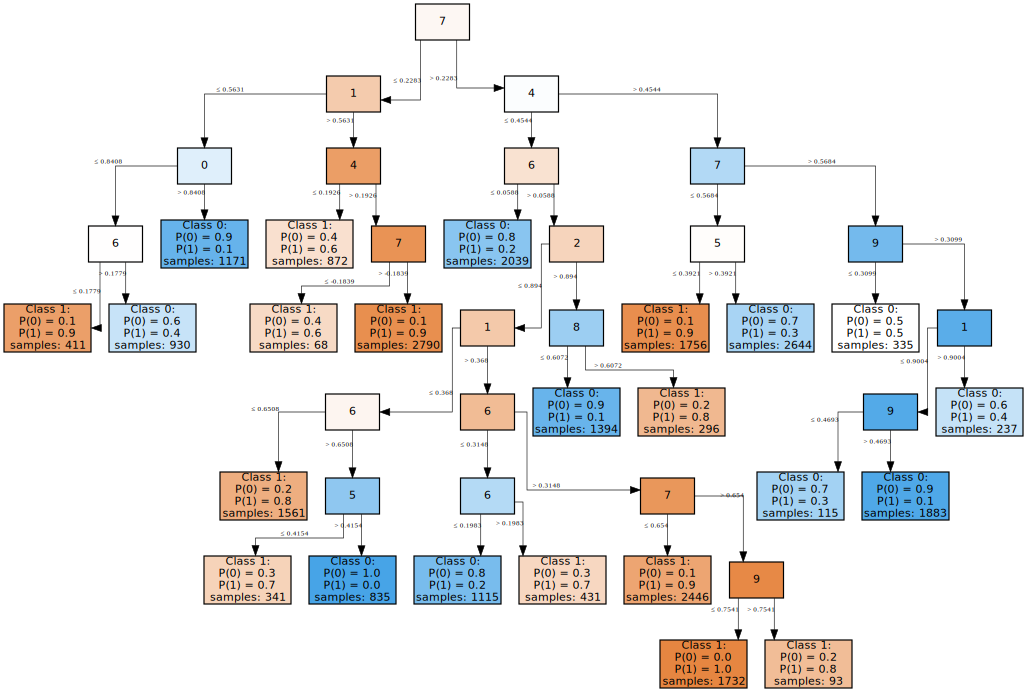

In [31]:
model.draw()

# 6. Concept drift

Um dos aspectos centrais em online learning reside no fato que esperamos que as distribuições dos dados podem ser não-estacionárias. Mas o que isso significa?

Primeiro, vamos pensar num exemplo de distribução estacionária:

> Sabe quando ouvimos falar que a GRANDE-EMPRESA-HYPADA lançou uma rede neural MASTER-BLASTER-ULTRA-POWER-3, com 3 troçalhões de parâmetros, treinada por 3 meses com a energia suficiente para alimentar cidades? E sabe quando ouvimos falar que a base de dados utilizada foi gigante?

Pois bem, os dados não mudam. As regras linguísticas no textos de entrada (supondo um modelo de linguagem natural) ou a semântica visual das imagens (supondo um modelo de visão computacional), ou qualquer outro exemplo, tudo isso é estático. Um cachorro continuará sendo um cachorro (independente do ângulo -- dependendo da forma de captação das imagens isso poderia ser um problema). Uma palavra tem um conjunto de sinônimos e significados.

A regra do jogo não-muda. Mas e se mudasse?

Essa mudança, ou deriva de conceito (concept drift) pode ocorrer em problemas do mundo real. Exemplo:

- padrões de consumo (papel higiênico e alcool em gel no início da pandemia)
- questões relacionadas a clima: energia sustentável
- trânsito, rotas

Umas das áreas de pesquisa (sim, uma área completa de pesquisa) em online learning busca criar detectores para essas situações, bem como algoritmos de aprendizado de máquina que sejam capazes de se adaptar mudanças de conceitos.

Estou longe de ser um especialista nesse tópico, mas vou dar um panorama de como as coisas acontecem.

Suponha que temos um problema de classificação e estamos monitorando os erros do nosso classificador. Nós assinalamos com $0$ quando o modelo acerta (erro zero) e $1$ quando o modelo erra.

In [32]:
rng = random.Random(8)

for _ in range(10):
    print(rng.choices([0, 1], weights=[0.7, 0.3])[0])

0
1
0
1
0
0
1
0
0
0


Podemos passar esses valores para um detector de drifts:

In [33]:
from river import drift

detector = drift.ADWIN(delta=0.01)

vals = rng.choices([0, 1], weights=[0.7, 0.3], k=500)
for i, v in enumerate(vals):
    detector.update(v)
    
    if detector.drift_detected:
        print(f"Drift detected: {i}")

E se a distribuição mudar?

In [34]:
detector = drift.ADWIN(delta=0.05)

vals = rng.choices([0, 1], weights=[0.7, 0.3], k=500)
vals.extend(rng.choices([0, 1], weights=[0.2, 0.8], k=500))
for i, v in enumerate(vals):
    detector.update(v)
    
    if detector.drift_detected:
        print(f"Drift detectado em {i}")

Drift detectado em 575


O ADWIN é um dos detectores mais utilizados, mas existem várias alternativas. Além disso, normalmente, os detectores são utilizados como componentes na criação de modelos preditivos. A forma na qual eles são utilizados difere de modelo para modelo. Uma característica é comum entre a maioria dos detectores de drift: eles são univariados.

# 7. Algorithm examples

I will present some examples of classification, regression, and clustering algorithms for reference. The API access is always the same, so you can try your luck and check other examples in the documentation.


## 7.1. Classification

Algorithms projected for binary classification can be extended to the multiclass case by relying on the tools available in the `multiclass` module:

- `OneVsOneClassifier`
- `OneVsRestClassifier`
- `OutputCodeClassifier`

River also have basics tools to handle multi-output tasks. Any contributions are welcome!

### 7.1.1. Hoeffding Trees

One of the most popular families of online machine learning algorithms. They take this name because the statistical measure called Hoeffding bound is used to define when splits are performed. This heuristic ensures the decisions taken in an incremental fashion are similar to those performed by a batch decision tree algorithm.


There are three main variants of Hoeffding Trees:

- Hoeffding Tree: vanilla version
- Hoeffding Adaptive Tree: adds drift detectors to each decision node. If a drift is detected, a new subtree is trained in the background, and eventually may replace the affected tree branch.
- Extremely Fast Decision Tree: quickly deploys splits, but later revisits and improves its own decisions.

**Main hyperparameters:**

- `grace_period`: interval between split attempts.
- `delta`: the split significance parameter. The split confidence `1 - delta`.
- `max_depth`: max height a tree might have.

I wrote a [tutorial](https://riverml.xyz/dev/user-guide/on-hoeffding-trees/) on Hoeffding Trees where you can find more details about trees.

**Example:**

In [35]:
from river import tree


dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)
model = tree.HoeffdingAdaptiveTreeClassifier(seed=42)
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=1000, show_memory=True, show_time=True)

[1,000] Accuracy: 56.06% – 00:00:00 – 38.11 KB
[2,000] Accuracy: 56.78% – 00:00:00 – 38.17 KB
[3,000] Accuracy: 57.42% – 00:00:01 – 38.23 KB
[4,000] Accuracy: 57.16% – 00:00:01 – 38.23 KB
[5,000] Accuracy: 56.93% – 00:00:01 – 38.23 KB
[6,000] Accuracy: 56.68% – 00:00:02 – 68.83 KB
[7,000] Accuracy: 57.14% – 00:00:02 – 69.7 KB
[8,000] Accuracy: 58.17% – 00:00:02 – 69.89 KB
[9,000] Accuracy: 58.65% – 00:00:03 – 70.02 KB
[10,000] Accuracy: 59.07% – 00:00:03 – 101.2 KB
[11,000] Accuracy: 59.73% – 00:00:04 – 101.45 KB
[12,000] Accuracy: 60.14% – 00:00:04 – 101.57 KB
[13,000] Accuracy: 60.67% – 00:00:04 – 101.7 KB
[14,000] Accuracy: 60.97% – 00:00:05 – 101.76 KB
[15,000] Accuracy: 60.94% – 00:00:05 – 132.56 KB


Accuracy: 60.94%

We can visualize the tree structure:

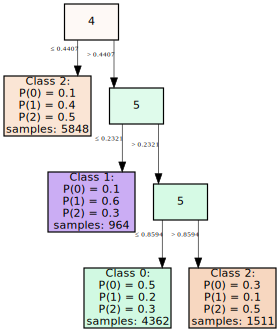

In [36]:
model.draw()

We can also inspect how decisions are made:

In [37]:
dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)

x, y = next(dataset)

print(model.debug_one(x))

4 ≤ 0.44069887341009073
Class 2:
	P(0) = 0.1
	P(1) = 0.4
	P(2) = 0.5



### 7.1.2. Adaptive Random Forest

Adaptive random forest (ARF) is an incremental version of Random Forests that combine the following ingredients:

- Randomized Hoeffding Trees as base learners
- Drifts detectors for each tree
    - New trees are trained in the background when drifts are detected
- Online bagging

ARFs have all the parameters of HTs and also some important extra parameters:

- `warning_detector` and `drift_detector`
- `n_models`: the number of trees
- `max_features`: the maximum number of features considered during split attempts at each decision node

**Example:**

In [38]:
from river import ensemble


dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)

model = ensemble.AdaptiveRandomForestClassifier(seed=8)
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=1000, show_memory=True, show_time=True)

[1,000] Accuracy: 65.67% – 00:00:01 – 1.04 MB
[2,000] Accuracy: 71.39% – 00:00:02 – 1.07 MB
[3,000] Accuracy: 73.06% – 00:00:03 – 2.27 MB
[4,000] Accuracy: 74.59% – 00:00:04 – 2.68 MB
[5,000] Accuracy: 75.98% – 00:00:06 – 3.96 MB
[6,000] Accuracy: 77.31% – 00:00:07 – 5.13 MB
[7,000] Accuracy: 77.85% – 00:00:08 – 3.8 MB
[8,000] Accuracy: 78.22% – 00:00:10 – 5.09 MB
[9,000] Accuracy: 78.25% – 00:00:11 – 6.41 MB
[10,000] Accuracy: 78.52% – 00:00:12 – 7 MB
[11,000] Accuracy: 78.36% – 00:00:14 – 8.38 MB
[12,000] Accuracy: 78.49% – 00:00:15 – 7.64 MB
[13,000] Accuracy: 78.58% – 00:00:16 – 8.97 MB
[14,000] Accuracy: 78.53% – 00:00:18 – 10.32 MB
[15,000] Accuracy: 78.41% – 00:00:19 – 10.76 MB


Accuracy: 78.41%

## 7.2. Regression


I will use the same dataset for every regression example:

In [39]:
def get_friedman():
    return synth.Friedman(seed=101).take(20000)

In [40]:
x, y = next(get_friedman())
x, y

({0: 0.5811521325045647,
  1: 0.1947544955341367,
  2: 0.9652511070611112,
  3: 0.9239764016767943,
  4: 0.46713867819697397,
  5: 0.6634706445300605,
  6: 0.21452296973796803,
  7: 0.22169624952624067,
  8: 0.28852243338125616,
  9: 0.6924227459953175},
 20.0094162975429)

### 7.2.2. Hoeffding Tree

(my research)

We have three main types of HTs for regression tasks:

- `HoeffdingTreeRegressor`: vanilla regressor.
- `HoeffdingAdaptiveTreeRegressor`: the regression counterpart of the adaptive classification tree.
- `iSOUPTreeRegressor`: Hoeffding Tree for multi-target regression tasks

Besides the parameters presented in the classification version, other important parameters are:

- `leaf_prediction`: the prediction strategy (regression or model tree)
- `leaf_model`: the regression model used in model trees' leaves
- `splitter`: the decision split algorithm

In [41]:
from river import preprocessing

metric = metrics.MAE() + metrics.RMSE() + metrics.R2()
model = preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor()

evaluate.progressive_val_score(
    dataset=get_friedman(),
    model=model,
    metric=metric,
    show_memory=True,
    show_time=True,
    print_every=2000
)

[2,000] MAE: 2.211476, RMSE: 2.922308, R2: 0.662991 – 00:00:00 – 975.25 KB
[4,000] MAE: 2.06573, RMSE: 2.711252, R2: 0.706024 – 00:00:00 – 1.57 MB
[6,000] MAE: 1.97555, RMSE: 2.570947, R2: 0.735164 – 00:00:00 – 2.19 MB
[8,000] MAE: 1.911936, RMSE: 2.481903, R2: 0.753895 – 00:00:01 – 2.73 MB
[10,000] MAE: 1.870939, RMSE: 2.424265, R2: 0.766415 – 00:00:01 – 3.27 MB
[12,000] MAE: 1.834748, RMSE: 2.375678, R2: 0.774293 – 00:00:01 – 3.86 MB
[14,000] MAE: 1.801622, RMSE: 2.329051, R2: 0.782718 – 00:00:01 – 4.36 MB
[16,000] MAE: 1.773081, RMSE: 2.292944, R2: 0.790029 – 00:00:02 – 5.11 MB
[18,000] MAE: 1.751902, RMSE: 2.264719, R2: 0.794645 – 00:00:02 – 6.19 MB
[20,000] MAE: 1.728428, RMSE: 2.234173, R2: 0.800588 – 00:00:02 – 6.35 MB


MAE: 1.728428, RMSE: 2.234173, R2: 0.800588

As usual, we can inspect how decisions are made:

In [42]:
x, y = next(get_friedman())

print(model.debug_one(x))

0. Input
--------
0: 0.58115 (float)
1: 0.19475 (float)
2: 0.96525 (float)
3: 0.92398 (float)
4: 0.46714 (float)
5: 0.66347 (float)
6: 0.21452 (float)
7: 0.22170 (float)
8: 0.28852 (float)
9: 0.69242 (float)

1. StandardScaler
-----------------
0: 0.28929 (float)
1: -1.07485 (float)
2: 1.58610 (float)
3: 1.47168 (float)
4: -0.11737 (float)
5: 0.56379 (float)
6: -0.99330 (float)
7: -0.96557 (float)
8: -0.73064 (float)
9: 0.67069 (float)

2. HoeffdingTreeRegressor
-------------------------
3 > -0.1
1 ≤ -0.8
3 > 0.6
0 > -0.9
4 > -0.9
2 > -1.1
1 > -1.5
Mean: 15.269219 | Var: 8.424779


Prediction: 18.29789


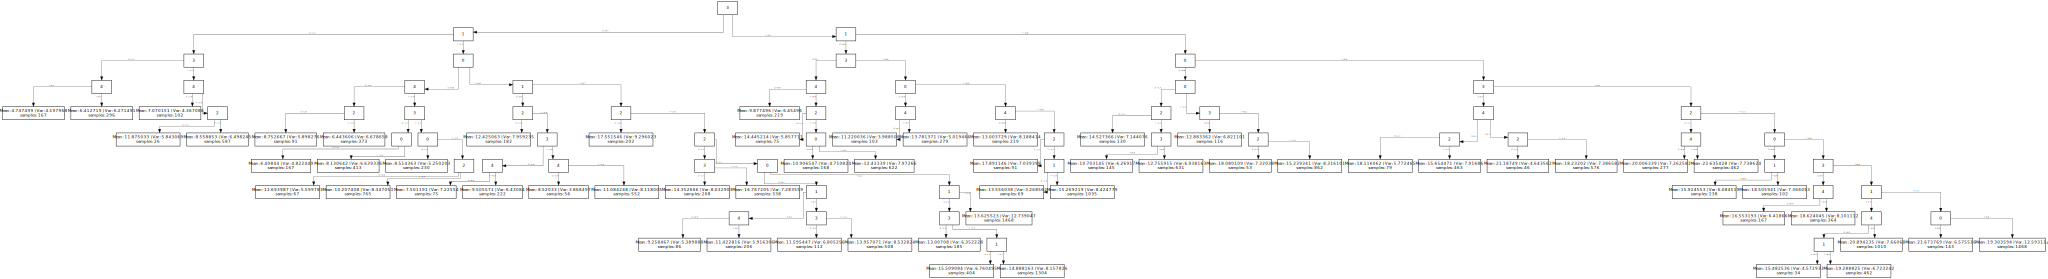

In [43]:
model["HoeffdingTreeRegressor"].draw()

### 7.2.3. AMRules

Adaptive Model Rules.

(also my research are)

Creates decision rules by relying on the Hoeffding Bound. AMRules also has anomaly detection capabilities, so it is capable of "skipping" anomalous training samples.

It has parameters similar to those of HTs:

- `n_min`: equivalent to `grace_period`
- `pred_type`: equivalent to `leaf_prediction`
- `pred_model`: equivalent to `leaf_model`
- `splitter`

Other important parameters:

- `m_min`: minimum number of instances to observe before start detecting anomalies.
- `drift_detector`: the drift detection algorithm used by each rule.
- `anomaly_threshold`: threshold to decide whether or not an instance is anomalous (the smaller the score value, the more anomalous is the instance).
- `ordered_rule_set`: defines if only the first rule is used for detection (when set to `True`) or all the rules are used (`False`).

In [44]:
from river import rules

metric = metrics.MAE() + metrics.RMSE() + metrics.R2()
model = preprocessing.StandardScaler() | rules.AMRules(
    splitter=tree.splitter.TEBSTSplitter(digits=1),  #  <- this is part of my research
    drift_detector=drift.ADWIN(),
    ordered_rule_set=False,
    m_min=100,
    delta=0.01
)

evaluate.progressive_val_score(
    dataset=get_friedman(),
    model=model,
    metric=metric,
    show_memory=True,
    show_time=True,
    print_every=2000
)

[2,000] MAE: 2.751126, RMSE: 3.585212, R2: 0.492754 – 00:00:00 – 557.26 KB
[4,000] MAE: 2.594004, RMSE: 3.401369, R2: 0.537321 – 00:00:00 – 0.98 MB
[6,000] MAE: 2.440782, RMSE: 3.200783, R2: 0.589509 – 00:00:00 – 1.06 MB
[8,000] MAE: 2.35917, RMSE: 3.094535, R2: 0.617403 – 00:00:01 – 1.08 MB
[10,000] MAE: 2.320284, RMSE: 3.045013, R2: 0.631478 – 00:00:01 – 1.29 MB
[12,000] MAE: 2.280378, RMSE: 2.994163, R2: 0.641474 – 00:00:01 – 1.18 MB
[14,000] MAE: 2.257398, RMSE: 2.963653, R2: 0.648179 – 00:00:02 – 1.51 MB
[16,000] MAE: 2.267085, RMSE: 2.982856, R2: 0.644666 – 00:00:02 – 1.92 MB
[18,000] MAE: 2.272122, RMSE: 2.98515, R2: 0.643212 – 00:00:03 – 2.08 MB
[20,000] MAE: 2.26724, RMSE: 2.983389, R2: 0.644419 – 00:00:03 – 2.18 MB


MAE: 2.26724, RMSE: 2.983389, R2: 0.644419

We can also inspect the model:

In [45]:
x, y = next(get_friedman())

print(model.debug_one(x))
print(f"True label: {y}")

0. Input
--------
0: 0.58115 (float)
1: 0.19475 (float)
2: 0.96525 (float)
3: 0.92398 (float)
4: 0.46714 (float)
5: 0.66347 (float)
6: 0.21452 (float)
7: 0.22170 (float)
8: 0.28852 (float)
9: 0.69242 (float)

1. StandardScaler
-----------------
0: 0.28929 (float)
1: -1.07485 (float)
2: 1.58610 (float)
3: 1.47168 (float)
4: -0.11737 (float)
5: 0.56379 (float)
6: -0.99330 (float)
7: -0.96557 (float)
8: -0.73064 (float)
9: 0.67069 (float)

2. AMRules
----------
Default rule triggered:
	Prediction (adaptive): 17.4743


Prediction: 17.47431
True label: 20.0094162975429


In [46]:
x_scaled = model["StandardScaler"].transform_one(x)

model["AMRules"].anomaly_score(x_scaled)

(-0.22130561042509, 0.0, 0)

and the pipeline:

In [47]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  AMRules (
    n_min=200
    delta=0.01
    tau=0.05
    pred_type="adaptive"
    pred_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Squared ()
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    splitter=TEBSTSplitter (
      digits=1
    )
    drift_detector=ADWIN (
      delta=0.002
    )
    alpha=0.99
    anomaly_threshold=-0.75
    m_min=100
    ordered_rule_set=False
    min_samples_split=5
  )
)

## 7.3. Clustering

Incremental algorithms must adapt to changes in the data. For instance, new clusters might appear, some might disappear. I will show one example of algorithm:

### 7.3.1. k-Means

There are multiple incremental versions of k-Means out there. The version available in River adds a parameter called `halflife` which controls the the intensity of the incremental updates.


In [48]:
from river import cluster

metric = metrics.Silhouette()
model = cluster.KMeans(seed=7)


for x, _ in get_friedman():
    metric.update(x, model.predict_one(x), model.centers)
    model.learn_one(x)

print(metric.get())

0.24465881722583005


In [49]:
metric = metrics.Silhouette()
model = cluster.KMeans(n_clusters=3, seed=7)


for x, _ in get_friedman():
    metric.update(x, model.predict_one(x), model.centers)
    model.learn_one(x)

print(metric.get())

0.6612806222738018


And increase the `halflife` value.

In [50]:
metric = metrics.Silhouette()
model = cluster.KMeans(n_clusters=3, seed=7, halflife=0.7)


for x, _ in get_friedman():
    metric.update(x, model.predict_one(x), model.centers)
    model.learn_one(x)

print(metric.get())

0.7161109032425856


# Extra reading

- [The art of using pipelines](https://riverml.xyz/latest/examples/the-art-of-using-pipelines/)
- [Working with imbalanced data](https://riverml.xyz/dev/examples/imbalanced-learning/)
- [Debbuging a pipeline](https://riverml.xyz/dev/examples/debugging-a-pipeline/)
